In [2]:
# import relevant packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.stats as ss
import seaborn as sns
from tqdm import tqdm

import torch
import torch_geometric
from torch_geometric.loader import DataLoader

# set figure parameters
sc.settings.set_figure_params(dpi=100)

In [3]:
from celcomen.models.celcomen import celcomen
from celcomen.models.simcomen import simcomen

In [4]:
from celcomen.training_plan.train import train
from celcomen.datareaders.datareader import get_dataset_loaders

In [18]:
from celcomen.utils.helpers import calc_gex, get_pos, get_pos, calc_sphex, normalize_g2g

In [6]:
# define a function to gather positions
# def get_pos(n_x, n_y):
#     # create the hex lattice
#     xs = np.array([np.arange(0, n_x) + 0.5 if idx % 2 == 0 else np.arange(0, n_x) for idx in range(n_y)])
#     # derive the y-step given a distance of one
#     y_step = np.sqrt(1**2+0.5**2)
#     ys = np.array([[y_step * idy] * n_x for idy in range(n_y)])
#     # define the positions
#     pos = np.vstack([xs.flatten(), ys.flatten()]).T
#     return pos
    
# # define a function to derive the gex from the sphex
# def calc_gex(sphex, device):
#     """
#     Calculates the gene expression matrix from the spherical
#     """
#     # setup the gex
#     n_genes = sphex.shape[1]+1
#     gex = torch.zeros((sphex.shape[0], n_genes), dtype=torch.float32).to(device)
#     # compute the gex
#     for idx in range(n_genes):
#         if idx == n_genes-1:
#             gex[:,idx] = torch.sin(sphex[:,idx-1])
#         else:
#             gex[:,idx] = torch.cos(sphex[:,idx])
#         for idx_ in range(idx):
#             gex[:,idx] *= torch.sin(sphex[:,idx_])
#     return gex

# from torch_geometric.nn import GCNConv
# from sklearn.neighbors import kneighbors_graph
# # define the number of neighbors (six for visium)
# n_neighbors = 6
# # define the simcomen class
# class simcomen(torch.nn.Module):
#     # define initialization function
#     def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
#         super(simcomen, self).__init__()
#         # define the seed
#         torch.manual_seed(seed)
#         # set up the graph convolution
#         self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
#         # set up the linear layer for intracellular gene regulation
#         self.lin = torch.nn.Linear(input_dim, output_dim)
#         # define the neighbors
#         self.n_neighbors = n_neighbors
#         # define a tracking variable for the gene expression x matrix
#         self.sphex = None
#         self.gex = None

#     # define a function to artificially set the g2g matrix
#     def set_g2g(self, g2g):
#         """
#         Artifically sets the core g2g matrix to be a specified interaction matrix
#         """
#         # set the weight as the input
#         self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=False)
#         # and then set the bias as all zeros
#         self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(n_genes).astype('float32')).to('cuda'), requires_grad=False)

#     # define a function to artificially set the g2g matrix
#     def set_g2g_intra(self, g2g_intra):
#         """
#         Artifically sets the core g2g intracellular matrix to be a specified matrix
#         """
#         # set the weight as the input
#         self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=False)
#         # and then set the bias as all zeros
#         self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')).to('cuda'), requires_grad=False)

#     # define a function to artificially set the sphex matrix
#     def set_sphex(self, sphex):
#         """
#         Artifically sets the current sphex matrix
#         """
#         self.sphex = torch.nn.Parameter(sphex, requires_grad=True)
        
#     # define the forward pass
#     def forward(self, edge_index, batch):
#         """
#         Forward pass for prediction or training,
#         convolutes the input by the expected interactions and returns log(Z_mft)
#         """
#         # compute the gex
#         self.gex = calc_gex(self.sphex, device=self.sphex.device )
#         # compute the message
#         msg = self.conv1(self.gex, edge_index)
#         # compute intracellular message
#         msg_intra = self.lin(self.gex)
#         # compute the log z mft
#         log_z_mft = self.log_Z_mft(edge_index, batch)
#         return msg, msg_intra, log_z_mft

#     # define approximation function
#     def log_Z_mft(self, edge_index, batch):
#         """
#         Mean Field Theory approximation to the partition function. Assumptions used are:
#         - expression of values of genes are close to their mean values over the visium slide
#         - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
#           interaction matrix.
#         """
#         # retrieve number of spots
#         num_spots = self.gex.shape[0]
#         # calculate mean gene expression        
#         mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
#         # calculate the norm of the sum of mean genes
#         g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
#         # calculate the contribution for mean values        
#         z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
#         # calculate the contribution gene interactions
#         z_interaction = self.z_interaction(num_spots=num_spots, g=g)
#         # add the two contributions        
#         log_z_mft = z_mean + z_interaction
#         return log_z_mft

#     def z_interaction(self, num_spots, g):
#         """
#         Avoid exploding exponentials by returning an approximate interaction term for the partition function.
#         """
#         if g>20:
#             z_interaction = num_spots * ( g - torch.log( g) )
#         else:
#             z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
#         return z_interaction
# # define the celcomen class
# class celcomen(torch.nn.Module):
#     # define initialization function
#     def __init__(self, input_dim, output_dim, n_neighbors, seed=0):
#         super(celcomen, self).__init__()
#         # define the seed
#         torch.manual_seed(seed)
#         # set up the graph convolution
#         self.conv1 = GCNConv(input_dim, output_dim, add_self_loops=False)
#         # set up the linear layer for intracellular gene regulation
#         self.lin = torch.nn.Linear(input_dim, output_dim)
#         # define the neighbors
#         self.n_neighbors = n_neighbors
#         # define a tracking variable for the gene expression x matrix
#         self.gex = None

#     # define a function to artificially set the g2g matrix
#     def set_g2g(self, g2g):
#         """
#         Artifically sets the core g2g matrix to be a specified interaction matrix
#         """
#         # set the weight as the input
#         self.conv1.lin.weight = torch.nn.Parameter(g2g, requires_grad=True)
#         # and then set the bias as all zeros
#         self.conv1.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g)).astype('float32')), requires_grad=False)

#     # define a function to artificially set the g2g matrix
#     def set_g2g_intra(self, g2g_intra):
#         """
#         Artifically sets the core g2g intracellular matrix to be a specified matrix
#         """
#         # set the weight as the input
#         self.lin.weight = torch.nn.Parameter(g2g_intra, requires_grad=True)
#         # and then set the bias as all zeros
#         self.lin.bias = torch.nn.Parameter(torch.from_numpy(np.zeros(len(g2g_intra)).astype('float32')), requires_grad=False)

#     # define a function to artificially set the sphex matrix
#     def set_gex(self, gex):
#         """
#         Artifically sets the current sphex matrix
#         """
#         self.gex = torch.nn.Parameter(gex, requires_grad=False)
        
#     # define the forward pass
#     def forward(self, edge_index, batch):
#         """
#         Forward pass for prediction or training,
#         convolutes the input by the expected interactions and returns log(Z_mft)
#         """
#         # compute the message
#         msg = self.conv1(self.gex, edge_index)
#         # compute intracellular message
#         msg_intra = self.lin(self.gex)
#         # compute the log z mft
#         log_z_mft = self.log_Z_mft(edge_index, batch)
#         return msg, msg_intra, log_z_mft

#     # define approximation function
#     def log_Z_mft(self, edge_index, batch):
#         """
#         Mean Field Theory approximation to the partition function. Assumptions used are:
#         - expression of values of genes are close to their mean values over the visium slide
#         - \sum_b g_{a,b} m^b >0 \forall a, where m is the mean gene expression and g is the gene-gene
#           interaction matrix.
#         """
#         # retrieve number of spots
#         num_spots = self.gex.shape[0]
#         # calculate mean gene expression        
#         mean_genes = torch.mean(self.gex, axis=0).reshape(-1,1)  # the mean should be per connected graph
#         # calculate the norm of the sum of mean genes
#         g = torch.norm(torch.mm( self.n_neighbors*self.conv1.lin.weight + 2*self.lin.weight, mean_genes))   # maybe needs to change to g = torch.norm(torch.mm(mean_genes, self.conv1.lin.weight))
#         # calculate the contribution for mean values        
#         z_mean = - num_spots  * torch.mm(torch.mm(torch.t(mean_genes), self.lin.weight + 0.5 * self.n_neighbors * self.conv1.lin.weight),  mean_genes)
#         # calculate the contribution gene interactions
#         z_interaction = self.z_interaction(num_spots=num_spots, g=g)
#         # add the two contributions        
#         log_z_mft = z_mean + z_interaction
#         return log_z_mft

#     def z_interaction(self, num_spots, g):
#         """
#         Avoid exploding exponentials by returning an approximate interaction term for the partition function.
#         """
#         if g>20:
#             z_interaction = num_spots * ( g - torch.log( g) )
#         else:
#             z_interaction = num_spots * torch.log((torch.exp( g) - torch.exp(- g))/( g))
#         return z_interaction

# # define a function to normalize the g2g
# def normalize_g2g(g2g):
#     """
#     Addresses any small fluctuations in symmetrical weights
#     """
#     # symmetrize the values
#     g2g = (g2g + g2g.T) / 2
#     # force them to be between 0-1
#     g2g[g2g < 0] = 0
#     g2g[g2g > 1] = 1
#     # force the central line to be 1
#     for idx in range(len(g2g)):
#         g2g[idx, idx] = 1
#     return g2g

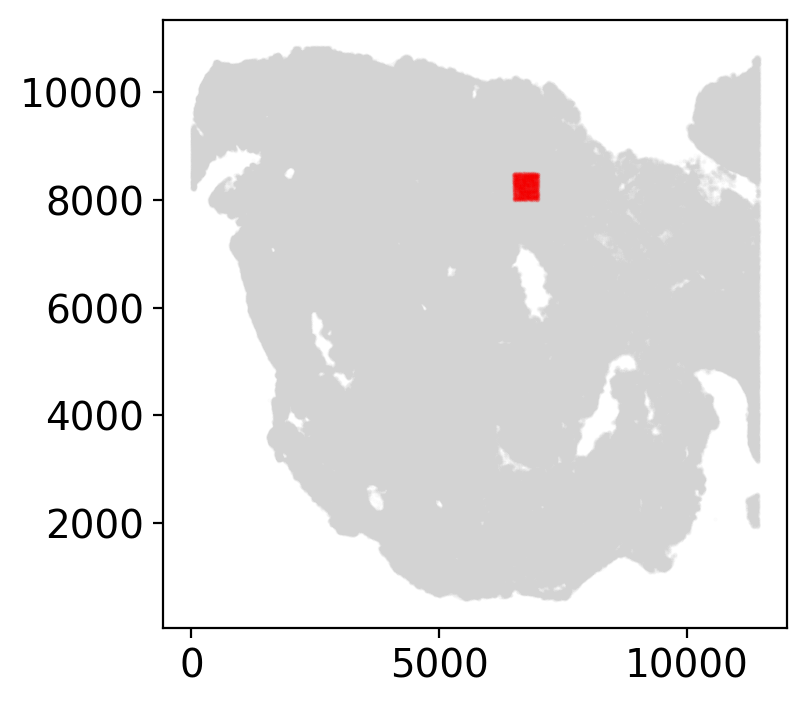

In [7]:
# read in xenium
avis = sc.read_10x_h5('data/xenium_human_gbm/cell_feature_matrix.h5')
avis.var_names = avis.var_names.astype(str)
avis.var_names_make_unique()
# remove cells with no counts
sc.pp.filter_cells(avis, min_counts=100)
# normalize the data
sc.pp.normalize_total(avis, target_sum=1e6)
sc.pp.log1p(avis)
# read in the spatial
df = pd.read_csv('data/xenium_human_gbm/cells.csv.gz', index_col=0)
df = df.loc[avis.obs.index]
# view the tissue and choose a specific area to focus on
fig, ax = plt.subplots()
ax.grid(False)
ax.scatter(df['x_centroid'], df['y_centroid'], s=0.1, alpha=0.1, color='lightgray')
mask = (df['x_centroid'] < 7000) & (df['x_centroid'] > 6500)
mask = mask & (df['y_centroid'] < 8500) & (df['y_centroid'] > 8000)
ax.scatter(df.loc[mask, 'x_centroid'], df.loc[mask, 'y_centroid'], s=0.1, alpha=0.1, color='r')

In [8]:
avis

AnnData object with n_obs × n_vars = 628324 × 480
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'

/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:251: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
/nfs/team205/sm58/packages/celcomen_trials/pyg_env/celcomen_tutorial_env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:412: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


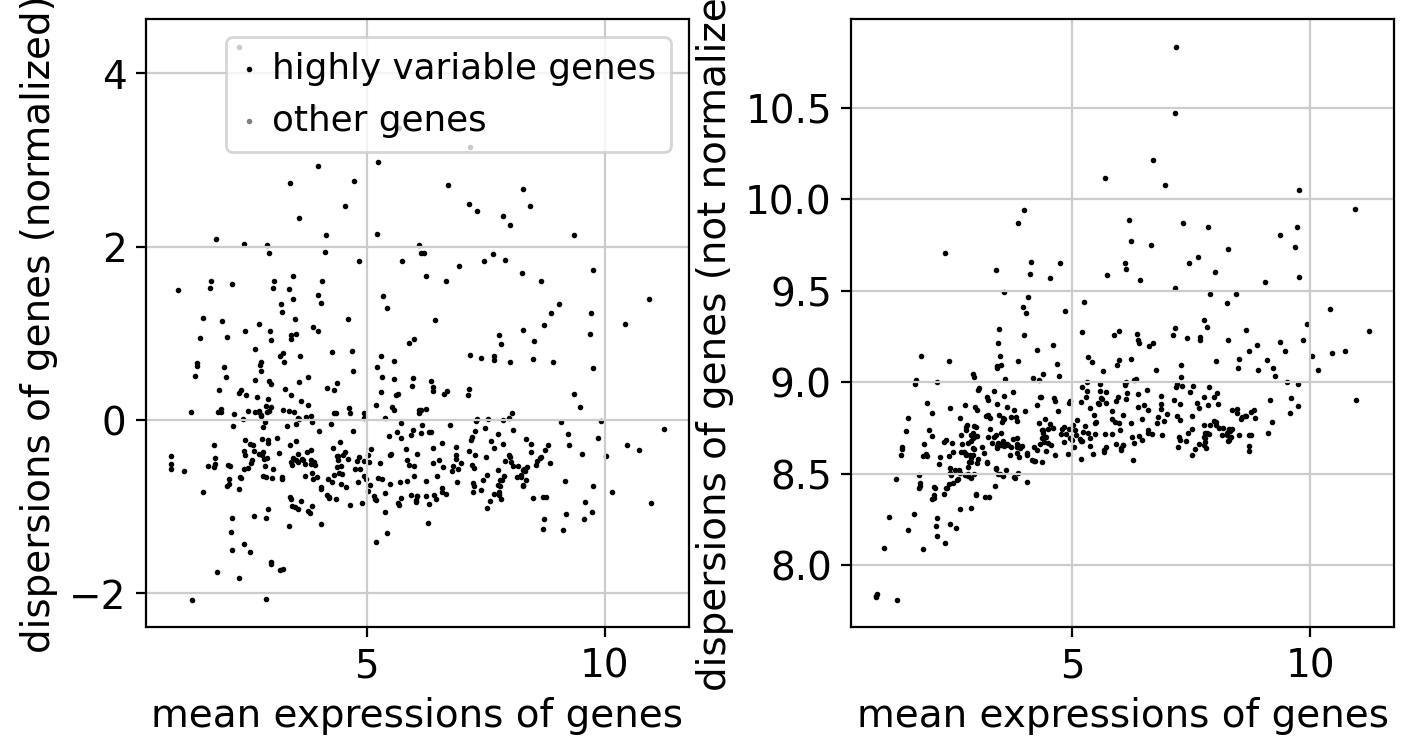

there are 480 hvgs


In [9]:
# add spatial and subset
avis.obsm['spatial'] = df.loc[avis.obs.index, ['x_centroid','y_centroid']].values
avis = avis[mask].copy()
# compute PCA for the spatial dataset using HVGs
avis.uns['log1p']['base'] = np.e
sc.pp.highly_variable_genes(avis, flavor='seurat', min_mean=0.5, max_mean=7.5, min_disp=0.5, n_top_genes=avis.shape[1])
sc.pl.highly_variable_genes(avis)
# report how many HVGs we're going to use
print('there are', avis.var['highly_variable'].sum(), 'hvgs')

In [10]:
from scipy.spatial.distance import pdist, squareform
# create a gene subset for testing
genes = avis.var_names[avis.var['highly_variable']].tolist()
avis = avis[:, genes ].copy()

# retrieve positions from the data # only needed for simcomen later
pos = torch.from_numpy(df[['x_centroid','y_centroid']].values)
# convert the gene expression data to numpy
x = torch.from_numpy(avis[:, genes].X.todense())
# sphere normalize the data (just in case)
norm_factor = torch.pow(x, 2).sum(1).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# compute the distances
distances = squareform(pdist(df.loc[mask, ['x_centroid','y_centroid']]))
# compute the edges as two cell widths apart so 30µm
edge_index = torch.from_numpy(np.array(np.where((distances < 15)&(distances != 0))))

avis.obs["sangerID"] = "sample1"

avis.write_h5ad(
    'data/xenium_human_gbm/avis_for_debug_loading.h5',
)


# define the parameters of the model
n_genes = len(genes)
learning_rate = 5e-2
zmft_scalar = 1e-1
seed = 0
epochs = 200
n_neighbors = 6
# instantiate the model, input and output will be the same
model_rev = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)

In [11]:
# from torch_geometric.loader import DataLoader
# import scanpy as sc
# import torch
# import torch_geometric
# #from torch_cluster.knn import knn_graph
# from sklearn.neighbors import kneighbors_graph
# import numpy as np

# from scipy.spatial.distance import pdist, squareform


# def get_dataset_loaders2(h5ad_path: str, sample_id_name: str, n_neighbors: int, verbose: bool):
#     """
#     Prepares and returns PyTorch Geometric DataLoader from a single-cell spatial transcriptomics dataset.

#     The function reads a single-cell AnnData object from an H5AD file, normalises the data, and generates 
#     graph data where nodes correspond to cells, and edges are created based on spatial proximity using 
#     a k-nearest neighbours graph. The data is then loaded into a PyTorch Geometric `DataLoader`.

#     Parameters
#     ----------
#     h5ad_path : str
#         Path to the H5AD file containing the single-cell spatial transcriptomics data.
#     sample_id_name : str
#         Name of the sample ID column in `adata.obs` to separate the dataset into different samples.
#     n_neighbors : int
#         Number of neighbours to use for constructing the k-nearest neighbours graph for spatial information.
#     verbose : bool
#         If True, prints detailed information about the DataLoader during the loading process.

#     Returns
#     -------
#     DataLoader
#         A PyTorch Geometric DataLoader containing the processed graph data, with each graph representing
#         a sample of cells in the dataset.

#     Notes
#     -----
#     - The spatial positions of the cells are used to create a k-nearest neighbours graph, with edges
#       connecting cells that are spatially close to each other.
#     - The input features for the graph (`x`) are normalised before constructing the graph.
#     - `adata.obsm["spatial"]` is used to extract the spatial coordinates of the cells.
#     - The graph data is validated using PyTorch Geometric's built-in validation method.

#     Examples
#     --------
#     >>> loader = get_dataset_loaders('data.h5ad', 'sample_id', n_neighbors=6, verbose=True)
#     Step 1
#     =====
#     Number of graphs in the current batch: 1
#     Data(x=[100, 33500], edge_index=[2, 500], pos=[100, 2], y=[1])

#     Raises
#     ------
#     ValueError
#         If there are issues with the input data during validation, e.g., if the graph is not well-formed.
#     """

#     adata = sc.read_h5ad(h5ad_path) 

#     # sc.pp.normalize_total(adata, target_sum=1e6)
#     # sc.pp.log1p(adata)

#     adata_list = [  adata[adata.obs[sample_id_name]==i] for i in set(adata.obs[sample_id_name])  ]

#     data_list = []
#     n_neighbors = 6

#     for adata in adata_list:
#         pos = torch.from_numpy(adata.obsm["spatial"])
#         x = torch.from_numpy(adata.X.todense())    # here x is nodes x 33500 -> add filteration here to take "best" 100
#         # normalize x 
#         norm_factor = torch.pow(x,2).sum(1).reshape(-1,1)
#         x = torch.div(x, norm_factor)
#         y = torch.Tensor([0])   # here we will store GT value
#         #edge_index = knn_graph(pos, k=n_neighbors)
#         distances = squareform(pdist(df.loc[mask, ['x_centroid','y_centroid']]))
#         # compute the edges as two cell widths apart so 30µm
#         edge_index = torch.from_numpy(np.array(np.where((distances < 15)&(distances != 0)))).to('cuda')
#         data = torch_geometric.data.Data(x=x, pos=pos, y=y, edge_index=edge_index)
#         data.validate(raise_on_error=True)    # performs basic checks on the graph
#         data_list.append(data)

#     loader = DataLoader( data_list, batch_size=1, shuffle=True)

#     if verbose:
#         for step, data in enumerate(loader):
#             print(f'Step {step+1}')
#             print("=====")
#             print(f'Number of graphs in the current batch: {data.num_graphs}')
#             print(data)
#             print()

#     return loader

In [12]:
avis

AnnData object with n_obs × n_vars = 1781 × 480
    obs: 'n_counts', 'sangerID'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'spatial'

In [13]:
h5ad_path='data/xenium_human_gbm/avis_for_debug_loading.h5'

loader = get_dataset_loaders(h5ad_path, "sangerID", 6, 'cuda', True, )

Step 1
=====
Number of graphs in the current batch: 1
DataBatch(x=[1781, 480], edge_index=[2, 7724], y=[1], pos=[1781, 2], batch=[1781], ptr=[2])



In [14]:
# def train1(epochs, learning_rate, model, loader, zmft_scalar=1e-1, seed=1, device="cpu", verbose=False):
#     """
#     Trains the model using a stochastic gradient descent (SGD) optimizer over the specified number of epochs.

#     During training, the model calculates messages between genes based on gene-to-gene (G2G) interactions 
#     and applies a Mean Field Theory (MFT) approximation for gene expression interactions. 
#     The G2G and intracellular regulation matrices are normalized after each step.

#     Parameters
#     ----------
#     epochs : int
#         Number of training epochs to run.
#     learning_rate : float
#         Learning rate for the SGD optimizer.
#     model : torch.nn.Module
#         The model to be trained, which includes a graph convolutional layer and a linear layer.
#     loader : torch_geometric.loader.DataLoader
#         DataLoader that provides the data for each batch during training.
#     zmft_scalar : float, optional
#         Scalar to weight the Mean Field Theory term in the loss function. Default is 1e-1.
#     seed : int, optional
#         Seed for random number generation to ensure reproducibility. Default is 1.
#     device : str, optional
#         Device to use for training, e.g., "cpu" or "cuda". Default is "cpu".
#     verbose : bool, optional
#         If True, prints the loss at each epoch. Default is False.

#     Returns
#     -------
#     losses : list of float
#         List of losses recorded at each epoch.

#     Examples
#     --------
#     >>> losses = train(epochs=100, learning_rate=0.01, model=my_model, loader=my_loader, zmft_scalar=1e-1, seed=42, device="cuda")
#     >>> print(losses[-1])  # Final loss
#     """    
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
#     losses = []
#     model.train()
#     torch.manual_seed(seed)
    
#     for epoch in tqdm(range(epochs), total=epochs):
#         losses_= []

#         for data in loader:
#             # move data to device
#             data = data.to(device)
#             # train loader  # Iterate in batches over the training dataset.
#             # set the appropriate gex
#             model.set_gex(data.x)
#             # derive the message as well as the mean field approximation
#             msg, msg_intra, log_z_mft = model(data.edge_index, 1)
#             # compute the loss and track it
#             loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(model.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
#             if device=="cpu":
#                 losses_.append(loss.detach().numpy()[0][0])
#             else:
#                 losses_.append(loss.detach().cpu().numpy()[0][0])
#             # derive the gradients, update, and clear
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#             # repeatedly force a normalization
#             model.conv1.lin.weight = torch.nn.Parameter(normalize_g2g(model.conv1.lin.weight), requires_grad=True)
#             model.lin.weight = torch.nn.Parameter(normalize_g2g(model.lin.weight), requires_grad=True)
#             optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
            
#         if verbose: print(f"Epoch={epoch}   |   Loss={np.mean(losses_)}")
#         losses.append(np.mean(losses_))

#     return losses

In [15]:
# def calc_gex(sphex, device):
#     """
#     Calculates the gene expression matrix from the spherical
#     """
#     # setup the gex
#     n_genes = sphex.shape[1]+1
#     gex = torch.zeros((sphex.shape[0], n_genes), dtype=torch.float32).to(device)

    

In [16]:
# # define a function to derive the gex from the sphex
# def calc_gex(sphex, device):
#     """
#     Converts a spherical gene expression matrix into a standard gene expression matrix.

#     The function takes a spherical expression matrix (`sphex`) and calculates the corresponding 
#     gene expression matrix (`gex`) using trigonometric functions such as sine and cosine. 
#     The last gene is computed using sine, and the others are computed using cosine, followed by 
#     multiplying by the sine of all preceding dimensions.

#     Parameters
#     ----------
#     sphex : torch.Tensor
#         The spherical gene expression matrix. Expected shape is (n_samples, n_features - 1).

#     Returns
#     -------
#     gex : torch.Tensor
#         The computed gene expression matrix of shape (n_samples, n_features), where `n_features` is one more than in `sphex`.
#         All NaN values are replaced with 0.

#     Examples
#     --------
#     >>> sphex = torch.tensor([[0.5, 0.6], [0.3, 0.4]])
#     >>> gex = calc_gex(sphex)
#     >>> print(gex)
#     tensor([[0.8776, 0.5646, 0.4794],
#             [0.9553, 0.5646, 0.2955]])
#     """
#     # setup the gex
#     n_genes = sphex.shape[1]+1
#     gex = torch.zeros((sphex.shape[0], n_genes), dtype=torch.float32).to(device)
#     #gex = torch.from_numpy(np.zeros((sphex.shape[0], n_genes)).astype('float32'))
#     # compute the gex
#     for idx in range(n_genes):
#         if idx == n_genes-1:
#             gex[:,idx] = torch.sin(sphex[:,idx-1])
#         else:
#             gex[:,idx] = torch.cos(sphex[:,idx])
#         for idx_ in range(idx):
#             gex[:,idx] *= torch.sin(sphex[:,idx_])
#     return torch.nan_to_num(gex)

# # define a function to gather positions
# def get_pos(n_x, n_y):
#     """
#     Generates a 2D hexagonal grid of positions.

#     This function creates a hexagonal lattice for a 2D grid, where the x-coordinates are adjusted
#     for alternating rows. The y-coordinates are spaced based on a predefined step size derived 
#     from the geometry of a hexagonal grid.

#     Parameters
#     ----------
#     n_x : int
#         Number of positions along the x-axis.
#     n_y : int
#         Number of positions along the y-axis.

#     Returns
#     -------
#     pos : numpy.ndarray
#         A 2D array of shape (n_x * n_y, 2) representing the coordinates of the positions on the hexagonal grid.

#     Examples
#     --------
#     >>> pos = get_pos(3, 3)
#     >>> print(pos)
#     array([[0.5, 0. ],
#            [1.5, 0. ],
#            [2.5, 0. ],
#            [0. , 1.11803399],
#            [1. , 1.11803399],
#            [2. , 1.11803399],
#            [0.5, 2.23606798],
#            [1.5, 2.23606798],
#            [2.5, 2.23606798]])
#     """
#     # create the hex lattice
#     xs = np.array([np.arange(0, n_x) + 0.5 if idx % 2 == 0 else np.arange(0, n_x) for idx in range(n_y)])
#     # derive the y-step given a distance of one
#     y_step = np.sqrt(1**2+0.5**2)
#     ys = np.array([[y_step * idy] * n_x for idy in range(n_y)])
#     # define the positions
#     pos = np.vstack([xs.flatten(), ys.flatten()]).T
#     return pos


# # define a function to normalize the g2g
# def normalize_g2g(g2g):
#     """
#     Symmetrizes and normalizes a gene-to-gene (G2G) interaction matrix.

#     This function ensures that the matrix is symmetrical, normalizes values to be between 0 and 1, 
#     and forces the diagonal to be 1 (representing self-interactions).

#     Parameters
#     ----------
#     g2g : numpy.ndarray
#         The gene-to-gene interaction matrix, typically of shape (n_genes, n_genes).

#     Returns
#     -------
#     g2g : numpy.ndarray
#         The normalized and symmetrized gene-to-gene interaction matrix.

#     Examples
#     --------
#     >>> g2g = np.array([[0.8, 0.2], [0.1, 0.7]])
#     >>> normalized_g2g = normalize_g2g(g2g)
#     >>> print(normalized_g2g)
#     array([[1. , 0.15],
#            [0.15, 1. ]])
#     """
#     # symmetrize the values
#     g2g = (g2g + g2g.T) / 2
#     # force them to be between 0-1
#     g2g[g2g < 0] = 0
#     g2g[g2g > 1] = 1
#     # force the central line to be 1
#     for idx in range(len(g2g)):
#         g2g[idx, idx] = 1
#     return g2g

# # define a function to derive the gex from the sphex
# def calc_sphex(gex):
#     """
#     Converts a standard gene expression matrix into a spherical expression matrix.

#     This function calculates the spherical representation of a gene expression matrix (`gex`), 
#     where the new features are derived using trigonometric functions such as arcsin and arccos.

#     Parameters
#     ----------
#     gex : torch.Tensor
#         The standard gene expression matrix, of shape (n_samples, n_genes).

#     Returns
#     -------
#     sphex : torch.Tensor
#         The spherical gene expression matrix, of shape (n_samples, n_genes - 1).

#     Examples
#     --------
#     >>> gex = torch.tensor([[0.8, 0.6, 0.4], [0.7, 0.5, 0.3]])
#     >>> sphex = calc_sphex(gex)
#     >>> print(sphex)
#     tensor([[1.5708, 0.5404],
#             [1.4706, 0.5236]])
#     """
#     # setup the gex
#     n_sgenes = gex.shape[1]-1
#     sphex = torch.from_numpy(np.zeros((gex.shape[0], n_sgenes)).astype('float32'))
#     # compute the gex
#     for idx in range(n_sgenes):
#         sphex[:,idx] = gex[:,idx]
#         for idx_ in range(idx):
#             sphex[:,idx] /= torch.sin(sphex[:,idx_])
#         sphex[:,idx] = torch.arccos(sphex[:,idx])
#     return sphex

In [19]:
n_neighbors=6
n_genes = len(genes)
learning_rate = 5e-2
zmft_scalar = 1e-1
seed = 0
epochs = 200


model = celcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
model.to("cuda")
input_g2g = np.random.uniform(size=(n_genes, n_genes)).astype('float32')
input_g2g = normalize_g2g((input_g2g + input_g2g.T) / 2)

model.set_g2g(torch.from_numpy(input_g2g))
model.set_g2g_intra(torch.from_numpy(input_g2g))
model.to("cuda")

losses = train(epochs, learning_rate, model, loader, zmft_scalar=zmft_scalar, seed=1, device="cuda")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.00it/s]


[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'loss')]

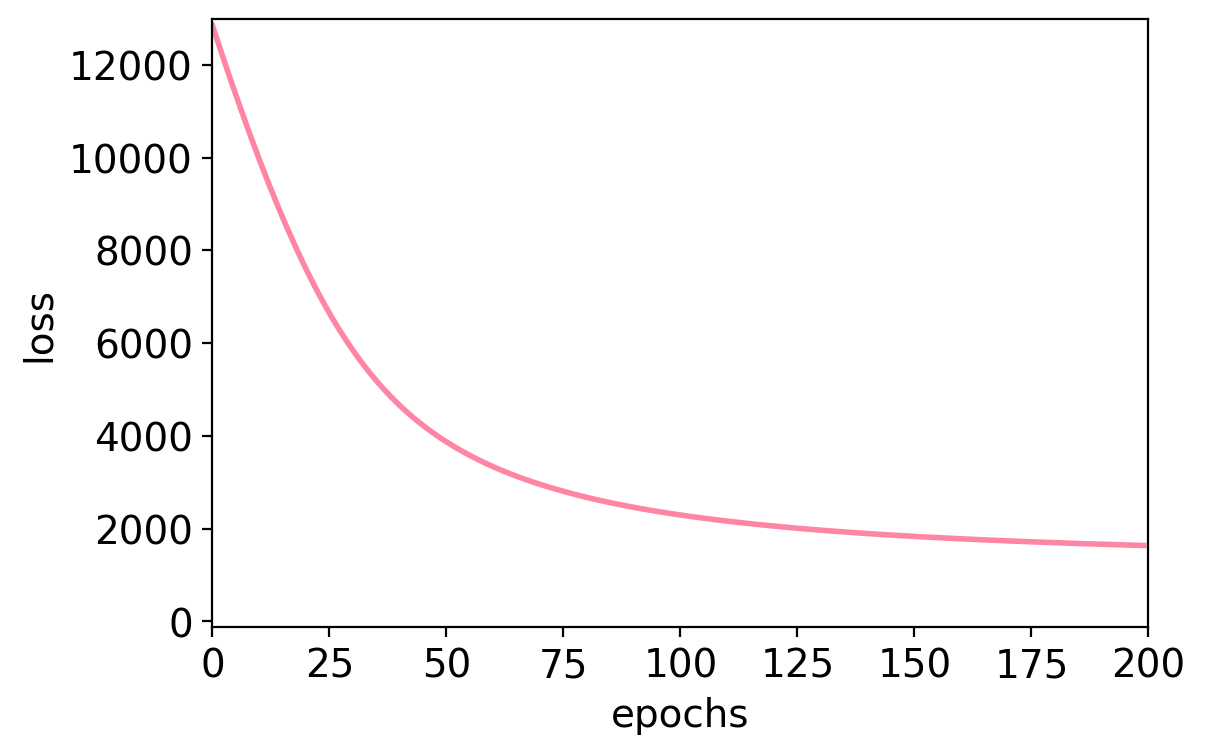

In [20]:
# create the plot
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')

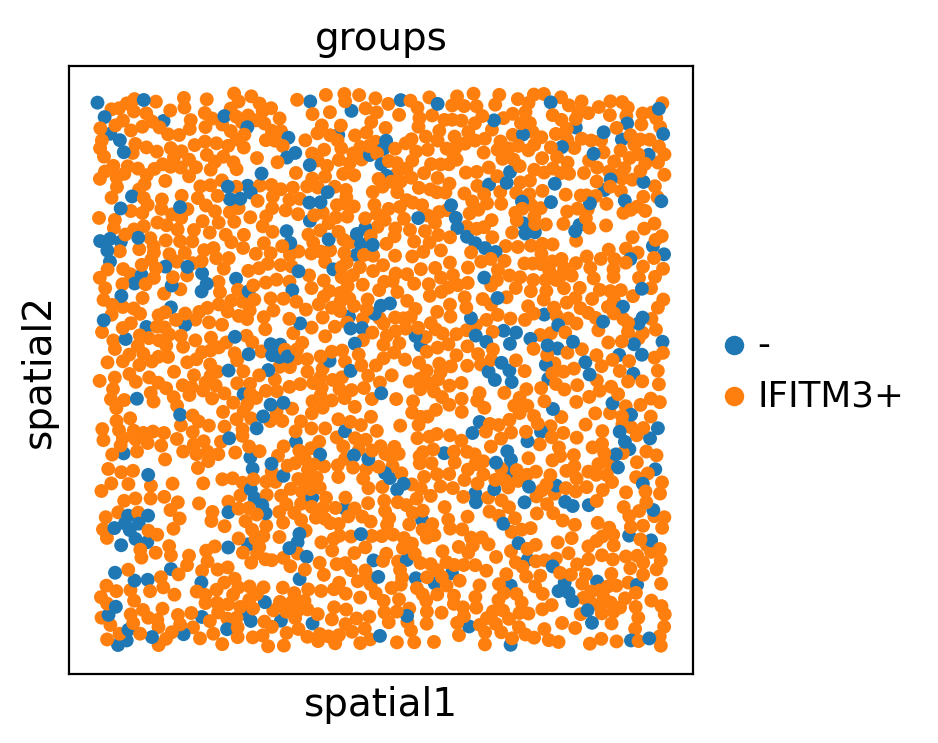

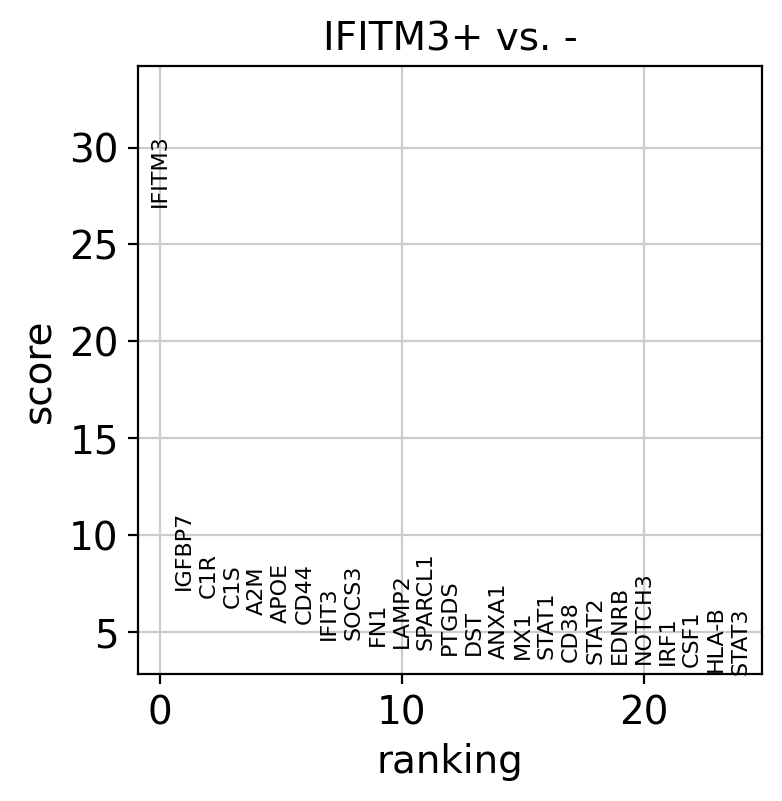

In [21]:
# define the genes that distinguish ISG15 spots currently
avis_sub = avis.copy()
avis_sub.obs['groups'] = (sc.get.obs_df(avis_sub, keys=['IFITM3']).max(1) > 0).map({True:'IFITM3+', False:'-'})
sc.pl.embedding(avis_sub, basis='spatial', color=['groups'], use_raw=False, s=1e2)
# calculate differential expression
sc.tl.rank_genes_groups(avis_sub, method='wilcoxon', use_raw=False, groupby='groups', group=['IFITM3+'], reference='-')
sc.pl.rank_genes_groups(avis_sub, n_genes=25, sharey=False)

/tmp/ipykernel_1657485/1489802821.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 30)[1]] = 'perturbed-neighbors1'
/tmp/ipykernel_1657485/148

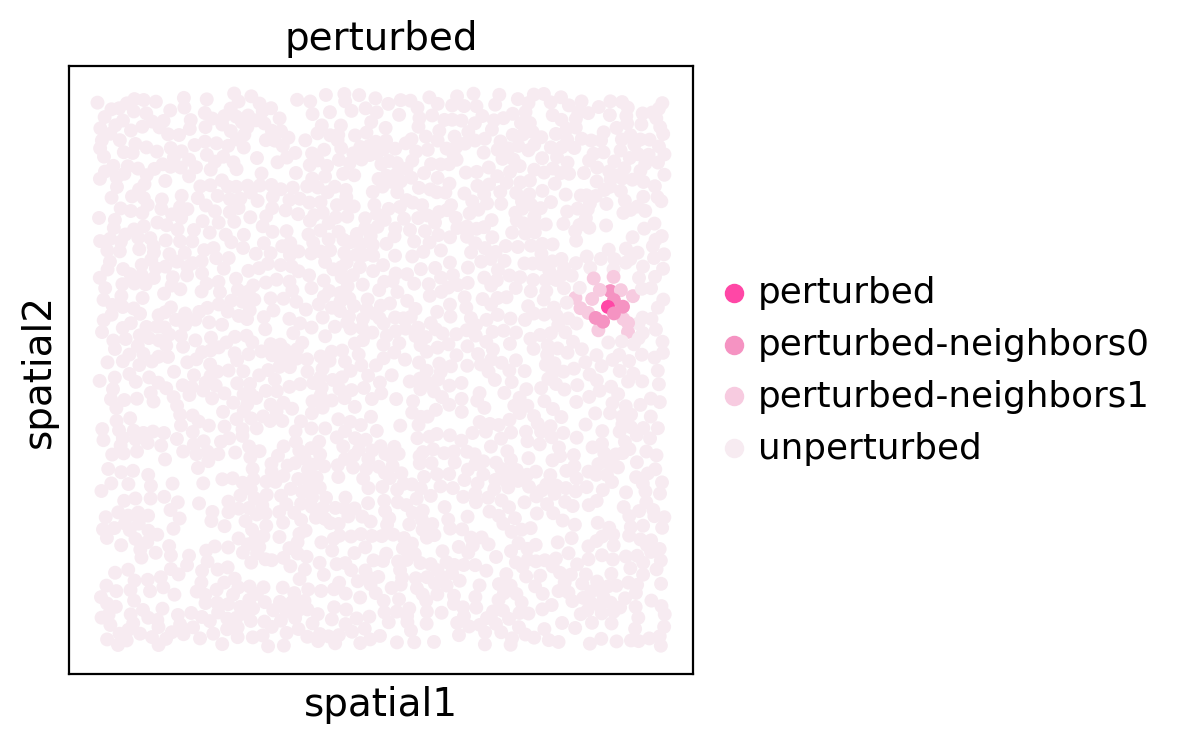

In [22]:
# propose an X introducing ISG15 inflammation
proposed_x = avis_sub.X.toarray().copy()
# adjust the X so we artificially introduce signaling to the center left side of the tissue
np.random.seed(0)
df_gex = sc.get.obs_df(avis_sub, keys=['IFITM3'])['IFITM3']
mask = avis_sub.obs.index == np.random.choice(avis_sub.obs.index[df_gex > 0], size=1)[0]
idx = np.where(avis_sub.var_names == 'IFITM3')[0][0]
proposed_x[mask, idx] = 0
avis_sub.obs['perturbed'] = 'unperturbed'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 30)[1]] = 'perturbed-neighbors1'
avis_sub.obs['perturbed'].iloc[np.where(squareform(pdist(avis_sub.obsm['spatial']))[mask, :] < 15)[1]] = 'perturbed-neighbors0'
avis_sub.obs.loc[mask, 'perturbed'] = 'perturbed'
avis_sub.uns['perturbed_colors'] = ['#ff47a6','#f593c2','#f7cbe0','#f7ebf1']
sc.pl.embedding(avis_sub, basis='spatial', color=['perturbed'], use_raw=False, s=1e2)

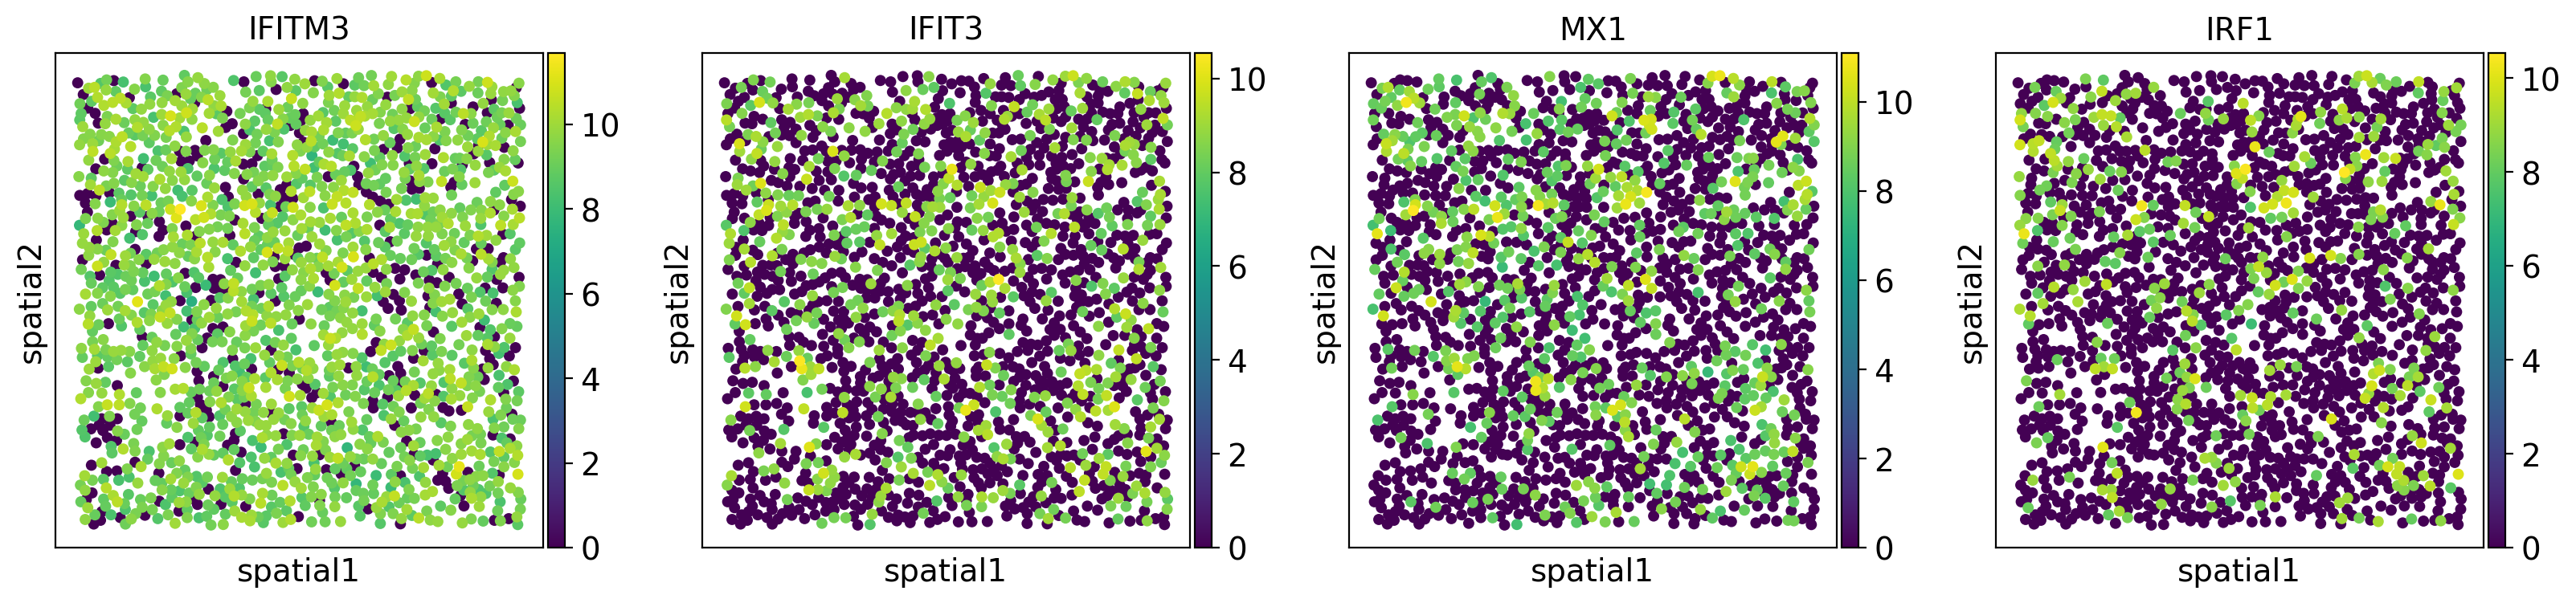

In [23]:
# demonstrate what the proposed x looks like pre scaling
avis_sub.X = proposed_x
sc.pl.embedding(avis_sub, basis='spatial', color=['IFITM3','IFIT3','MX1','IRF1'], use_raw=False, s=1e2)

In [24]:
# define the parameters of the model
n_genes = avis_sub.shape[1]
learning_rate = 1e-3
zmft_scalar = 1e-1
seed = 0
epochs = 50
# instantiate the model, input and output will be the same
simmodel = simcomen(input_dim=n_genes, output_dim=n_genes, n_neighbors=n_neighbors, seed=seed)
# now perform the simulation
np.random.seed(seed)
# convert the gene expression data to numpy
x = torch.from_numpy(proposed_x)
# sphere normalize the data (just in case)
norm_factor = torch.sqrt(torch.pow(x, 2).sum(1)).reshape(-1,1)
assert (norm_factor > 0).all()
x = torch.div(x, norm_factor)
# artifically set the g2g matrix
simmodel.set_g2g(model.conv1.lin.weight.clone().detach())
simmodel.set_g2g_intra(model.lin.weight.clone().detach())
# initialize a gene expression matrix
assert np.isnan(x.detach().numpy()).sum() == 0
input_sphex = calc_sphex(x.to('cuda')).clone()

# move tensors and model to device cuda
device="cuda"
simmodel.set_sphex(input_sphex)
simmodel.to("cuda")

simcomen(
  (conv1): GCNConv(480, 480)
  (lin): Linear(in_features=480, out_features=480, bias=True)
)

In [25]:
# set up the optimizer
optimizer = torch.optim.SGD(simmodel.parameters(), lr=learning_rate, momentum=0)
# keep track of the losses per data object
loss, losses = None, []
# train the model
simmodel.train()
tmp_gexs = []
# work through epochs
edge_index = edge_index.to('cuda')
for epoch in tqdm(range(epochs), total=epochs):
    # derive the message as well as the mean field approximation
    msg, msg_intra, log_z_mft = simmodel(edge_index, 1)
    if (epoch % 5) == 0:
        tmp_gex = simmodel.gex.clone().detach().cpu().numpy()
        tmp_gexs.append(tmp_gex)
    # compute the loss and track it
    loss = -(-log_z_mft + zmft_scalar * torch.trace(torch.mm(msg, torch.t(simmodel.gex))) + zmft_scalar * torch.trace(torch.mm(msg_intra, torch.t(model.gex))) )
    losses.append(loss.detach().cpu().numpy()[0][0])
    # derive the gradients, update, and clear
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  0%|                                                                                                                                                                                       | 0/50 [00:00<?, ?it/s]

self.gex device is cuda:0
edge_index device is cuda:0


  2%|███▌                                                                                                                                                                           | 1/50 [00:29<24:06, 29.53s/it]

self.gex device is cuda:0
edge_index device is cuda:0


  4%|███████                                                                                                                                                                        | 2/50 [00:59<23:55, 29.90s/it]

self.gex device is cuda:0
edge_index device is cuda:0


  6%|██████████▌                                                                                                                                                                    | 3/50 [01:30<23:54, 30.52s/it]

self.gex device is cuda:0
edge_index device is cuda:0


  8%|██████████████                                                                                                                                                                 | 4/50 [02:01<23:33, 30.72s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 10%|█████████████████▌                                                                                                                                                             | 5/50 [02:32<22:54, 30.54s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 12%|█████████████████████                                                                                                                                                          | 6/50 [03:03<22:31, 30.72s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 14%|████████████████████████▌                                                                                                                                                      | 7/50 [03:34<22:08, 30.89s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 16%|████████████████████████████                                                                                                                                                   | 8/50 [04:05<21:33, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 18%|███████████████████████████████▌                                                                                                                                               | 9/50 [04:36<21:08, 30.93s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 20%|██████████████████████████████████▊                                                                                                                                           | 10/50 [05:06<20:32, 30.81s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 22%|██████████████████████████████████████▎                                                                                                                                       | 11/50 [05:37<20:03, 30.86s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 24%|█████████████████████████████████████████▊                                                                                                                                    | 12/50 [06:08<19:34, 30.89s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 26%|█████████████████████████████████████████████▏                                                                                                                                | 13/50 [06:39<19:04, 30.93s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 28%|████████████████████████████████████████████████▋                                                                                                                             | 14/50 [07:10<18:33, 30.93s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 30%|████████████████████████████████████████████████████▏                                                                                                                         | 15/50 [07:41<17:57, 30.80s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 32%|███████████████████████████████████████████████████████▋                                                                                                                      | 16/50 [08:12<17:33, 30.99s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 34%|███████████████████████████████████████████████████████████▏                                                                                                                  | 17/50 [08:43<17:02, 30.98s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 36%|██████████████████████████████████████████████████████████████▋                                                                                                               | 18/50 [09:14<16:30, 30.95s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 38%|██████████████████████████████████████████████████████████████████                                                                                                            | 19/50 [09:44<15:54, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 40%|█████████████████████████████████████████████████████████████████████▌                                                                                                        | 20/50 [10:15<15:23, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 42%|█████████████████████████████████████████████████████████████████████████                                                                                                     | 21/50 [10:46<14:55, 30.86s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 44%|████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 22/50 [11:17<14:22, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 46%|████████████████████████████████████████████████████████████████████████████████                                                                                              | 23/50 [11:47<13:49, 30.73s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 48%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 24/50 [12:18<13:17, 30.68s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 50%|███████████████████████████████████████████████████████████████████████████████████████                                                                                       | 25/50 [12:49<12:50, 30.81s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 52%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 26/50 [13:20<12:20, 30.84s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 54%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                | 27/50 [13:50<11:45, 30.68s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 28/50 [14:21<11:17, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 29/50 [14:52<10:46, 30.77s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 30/50 [15:23<10:16, 30.84s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 31/50 [15:53<09:43, 30.69s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 32/50 [16:24<09:12, 30.71s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 33/50 [16:55<08:43, 30.78s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 34/50 [17:26<08:12, 30.77s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 35/50 [17:56<07:39, 30.64s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 36/50 [18:27<07:10, 30.74s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 37/50 [18:58<06:39, 30.76s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 38/50 [19:29<06:09, 30.79s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 39/50 [19:59<05:36, 30.59s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 40/50 [20:30<05:07, 30.75s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 41/50 [21:01<04:37, 30.78s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 42/50 [21:32<04:06, 30.78s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 43/50 [22:02<03:35, 30.74s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 44/50 [22:33<03:04, 30.68s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 45/50 [23:04<02:34, 30.80s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 46/50 [23:35<02:03, 30.76s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 47/50 [24:05<01:32, 30.69s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 48/50 [24:36<01:01, 30.68s/it]

self.gex device is cuda:0
edge_index device is cuda:0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 49/50 [25:07<00:30, 30.69s/it]

self.gex device is cuda:0
edge_index device is cuda:0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [25:38<00:00, 30.76s/it]


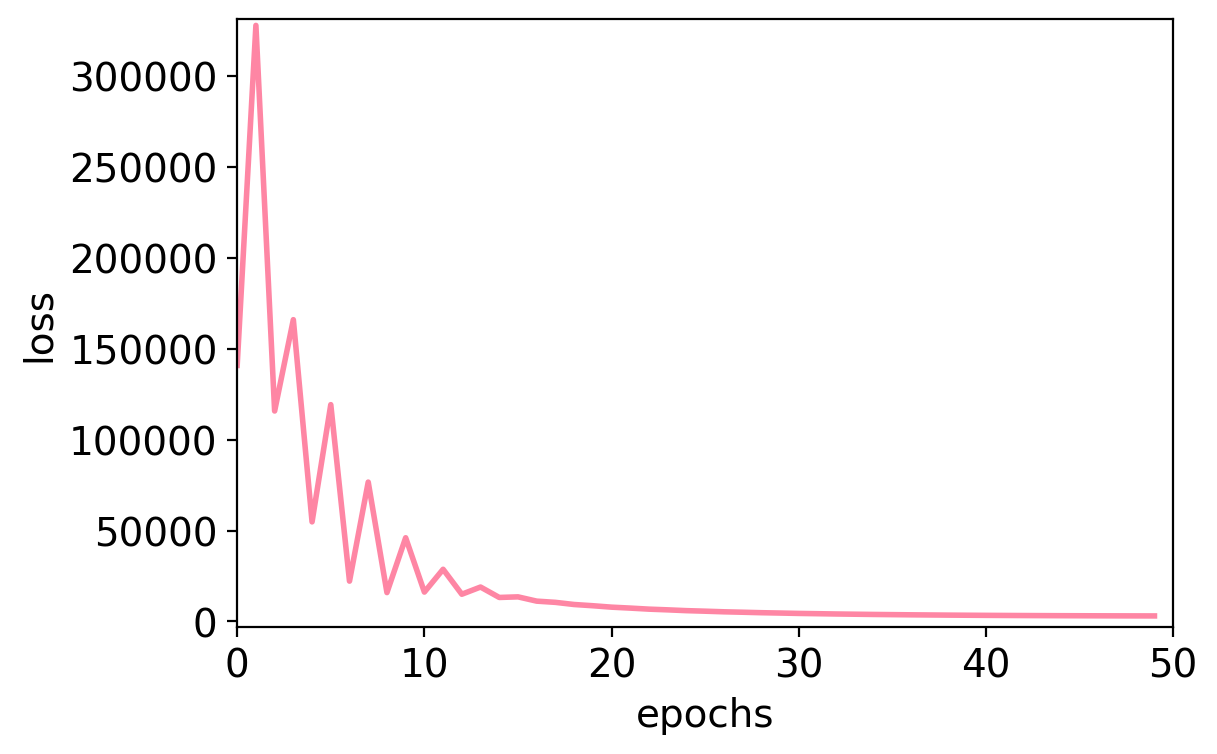

In [26]:
# plot the loss
fig, ax = plt.subplots(figsize=[6, 4])
ax.grid(False)
ax.plot(losses, lw=2, color='#fe86a4')
ax.set_xlim(0, epochs)
vmin, vmax = min(min(losses), 0), max(losses)
vstep = (vmax - vmin) * 0.01
ax.set_ylim(vmin-vstep, vmax+vstep)
ax.set(xlabel='epochs', ylabel='loss')
# retrieve the data
output_gex = simmodel.gex.detach().cpu().numpy()
output_msg = msg.detach().cpu().numpy()

In [ ]:
# find the genes of interest
genes = ['IFITM3','IFIT3','MX1','IRF1']
genes = [x for x in genes if x in avis_sub.var_names.tolist()]
# add the layers
for idx, tmp_gex in enumerate(tmp_gexs):
    avis_sub.layers[f'input{idx}'] = tmp_gex
avis_sub.layers['output'] = output_gex
# plot the genes of interest
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input0')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='input3')
sc.pl.embedding(avis_sub, basis='spatial', color=genes, use_raw=False, s=1e2, layer='output')

In [ ]:
# compute the differential within the area of interest vs outside
avis_sub.layers['diff'] = avis_sub.layers['output'] - avis_sub.layers['input0']
mask0 = avis_sub.obs['perturbed'] == 'unperturbed'
mask1 = avis_sub.obs['perturbed'] == 'perturbed'
diff_in_vs_out_p = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# now compute differential for neighbors
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
diff_in_vs_out_pn0 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
diff_in_vs_out_pn1 = pd.Series((avis_sub.layers['diff'][mask1].mean(0) - avis_sub.layers['diff'][mask0].mean(0)),
                             index=avis_sub.var_names).sort_values()[::-1]
# remove the perturbed genes to get a clean look
perturbed_genes = ['IFITM3']
perturbed_label = 'ifitm3'
diff_in_vs_out_p = diff_in_vs_out_p.loc[~diff_in_vs_out_p.index.isin(perturbed_genes)]
diff_in_vs_out_pn0 = diff_in_vs_out_pn0.loc[~diff_in_vs_out_pn0.index.isin(perturbed_genes)]
diff_in_vs_out_pn1 = diff_in_vs_out_pn1.loc[~diff_in_vs_out_pn1.index.isin(perturbed_genes)]
# write these matrices out
diff_in_vs_out_p.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_p.csv')
diff_in_vs_out_pn0.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn0.csv')
diff_in_vs_out_pn1.to_csv(f'20240618.learn_then_perturb.xenium_gbm.{perturbed_label}.diff_in_vs_out_pn1.csv')
# do not include isg15 itself
genes_ = pd.DataFrame(avis_sub.uns['rank_genes_groups']['names']).iloc[:25, 0].tolist()[1:]
# retrieve the results
df_expr = pd.DataFrame(columns=['p','pn0','pn1','u'])
for layer in ['input1','input2','input3','input4','input5','input6','input7','input8','input9','output']:
    # compute the expression
    mask1 = avis_sub.obs['perturbed'] == 'perturbed'
    expr_p = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors0'
    expr_pn0 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'perturbed-neighbors1'
    expr_pn1 = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    mask1 = avis_sub.obs['perturbed'] == 'unperturbed'
    expr_u = pd.Series(avis_sub.layers[layer][mask1].mean(0), index=avis_sub.var_names).loc[genes_].mean()
    df_expr.loc[layer] = expr_p, expr_pn0, expr_pn1, expr_u
# derive the scores
fig, ax = plt.subplots(figsize=[2.9, 5.6])
ax = sns.heatmap(df_expr, cmap='viridis')
ax.grid(False)